In [ ]:
# Optional: change Jupyter Notebook theme to GDD theme
from IPython.core.display import HTML
HTML(url='https://gdd.li/jupyter-theme')

![footer_logo](images/logo.png)
# Seasonality Modeling


## Goal

During this session we shall focus on modelling Time Series data. 

We shall learn about the different components we can identify in Time Series data and how they can be modelled.

We shall also discuss how a Time Series model can be used for outlier detection and how to evaluate our models.

## Program

1. [Time Series Decomposition](#ets)
2. [Linear Modeling Approach](#lma)
3. [Dealing with Seasonality](#dws)
4. [Gradual Seasonal Filtering](#gsf)
5. [Outlier Detection](#od)
6. [Forecast Evaluation for Seasonality Models](#eval)
7. [Summary](#sum)

In [2]:
import calendar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

plt.rcParams['figure.figsize'] = (16,4)

![footer_logo](images/air-quality.jpeg) 


## The Data

We will again use a dataset containing daily air quality index in Californian counties between 2007 and 2017 (based on a larger dataset from [Kaggle](https://www.kaggle.com/epa/carbon-monoxide)). 

Each datapoint indicates the average air quality index on a certain day: the higher the value - the more polluted.


In [3]:
air_df = pd.read_csv('data/air_quality.csv', index_col='date_local', parse_dates=True)
air_df.head()

,aqi
date_local,
2007-08-01,5.522124
2007-08-02,5.894895
2007-08-03,5.928358
2007-08-04,5.792285
2007-08-05,5.744807


By visualising the data we can we can identify some patterns,

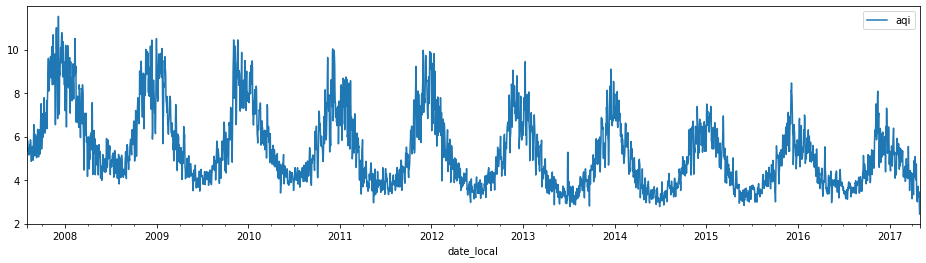

In [4]:
air_df.plot();

These regularities in the data can be categorised as follows:
- **Trends** (upward / horizontal / downward)
- **Seasonality** (predictably repeating cycles - weekly/monthly/yearly etc)
- **Cyclical components** (patterns with no period - for example trend breaks) 
- **Residuals** (the remaining part of the series that cannot be further explicitly modeled)

<a id='ets'></a>
## 1. Time Series decomposition

Seasonality is very common in business data. However, it can obscure the actual signal of the data, which complicates both understanding of the underlying processes and further forecasting. 

Accordingly, we may wish to separate Time Series data into its trend and seasonal components. This process is known as **Time Series decomposition**.

One of the simplest ways to identify the general trend is to substantially **smooth** the Time Series data. For example, the smoothed data clearly suggests a downward trend in AQI (or that air quality is improving).

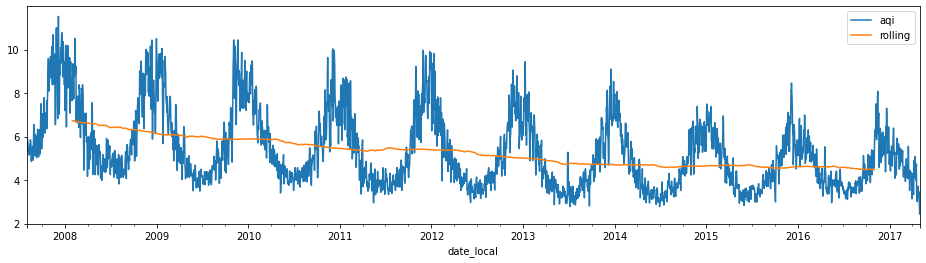

In [5]:
(
    air_df
    .assign(rolling = lambda df: df['aqi'].rolling(365, center=True).mean(),
            #exponential=lambda df: df['aqi'].ewm(alpha=0.001).mean()
           )
    .plot()
);

If we naively assume that the remaining variation is due to seasonality and noise, we can isolate this from the Time Series data too.

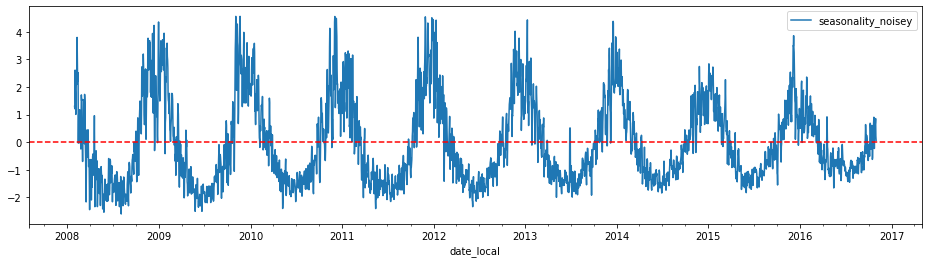

In [7]:
ax = (
    air_df
    .assign(rolling = lambda df: df['aqi'].rolling(365, center=True).mean(),
            seasonality_noisey = lambda df: df['aqi'] - df['rolling'],
            #seasonality_smoothed = lambda df: df['seasonality_noisey'].rolling(90, center=True).mean(),
            #error = lambda df: df['aqi'] - df['rolling'] - df['seasonality_smoothed']
           )
    [['seasonality_noisey']]
    #[['seasonality_noisey', 'seasonality_smoothed']]
    .plot()
)
ax.axhline(0, color='r', linestyle='--');
# Check seasonality as a single component

Notice how we still have the seasonal waves but without the downwards trend.

However, whilst smoothing can average out the effects of seasonality and noise, it does not provide us with a mathematical model that can describe the data and be used for forecasting. 

In addition to this the "centering" it involves makes use of information from the future, which would not be possible in the context of forecasting.


<a id='lma'></a>
## 2. Linear Modeling Approach

An alternative way to identify the main pattern(s) taking place in the data is to fit a linear regression. 

Even the most basic linear model with a single time component can inform us about the general trend and allow us to (mostly) separate it from the seasonality.

To demonstrate this we shall learn a linear regression model that is able to predict the AQI of a particular date.

We shall first create a variable to indicate which number time point the dates represent.

In [9]:
air_df['time_point'] = np.arange(len(air_df))
air_df.head()
# in an equation, we cannot include dates so we need an alternative
# y (aqi) = m (gradient) x (time point) + c (intercept) y = mx + c

,aqi,time_point
date_local,,
2007-08-01,5.522124,0
2007-08-02,5.894895,1
2007-08-03,5.928358,2
2007-08-04,5.792285,3
2007-08-05,5.744807,4


We then separate the data into a feature matrix **X** and target vetor **y** so we can fit a linear regression.

In [10]:
X = air_df[['time_point']]
y = air_df['aqi']

In [14]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X, y)

# just to capture the trend since it is a line

LinearRegression()

The predictions from this model represents the linear trend.

In [15]:
air_df['linear_trend'] = lm.predict(X)
air_df.head()
# liner_trend are the predictions from our model

,aqi,time_point,linear_trend
date_local,,,
2007-08-01,5.522124,0,6.548634
2007-08-02,5.894895,1,6.547952
2007-08-03,5.928358,2,6.547271
2007-08-04,5.792285,3,6.546589
2007-08-05,5.744807,4,6.545908


Let's visualise the outcome for the model on the data it was trained on.

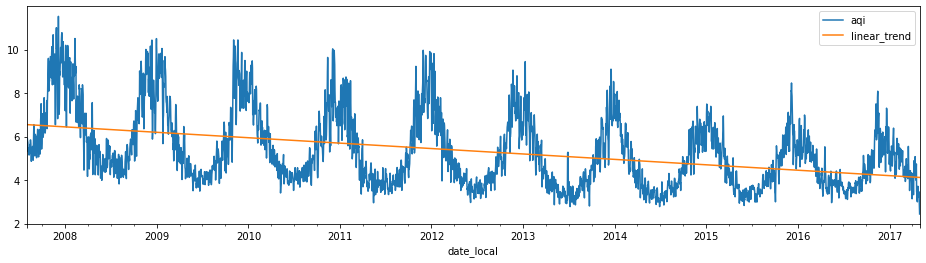

In [16]:
air_df[['aqi','linear_trend']].plot();

As simple as this is, it gives us an idea of what happens over time. 

Of course a single linear trend cannot take dynamical changes in growth/decline rates into account. 

For example the trend appears to change around summer 2014 (trend breaks).

<!-- https://en.wikipedia.org/wiki/Hurricane_Marie_(2014) -->

But we can take care of this by adding break indicators & interaction terms:
- The `after_summer_2014` indicator term will allows us to add a particular quantity depending on whether we are before or after the date 01/08/2014.
- The `interaction` term allows to add an additional quantities which are dependent on the time point.


In [22]:
X_break = (
    air_df
    .assign(after_summer_2014 = np.where(air_df.index > pd.Timestamp('2014-08'), 1, 0),
            interaction = lambda df: df['time_point']*df['after_summer_2014'])
    [['time_point', 'after_summer_2014','interaction']]
)
X_break

,time_point,after_summer_2014,interaction
date_local,,,
2007-08-01,0,0,0
2007-08-02,1,0,0
2007-08-03,2,0,0
2007-08-04,3,0,0
2007-08-05,4,0,0
...,...,...,...
2017-04-27,3557,1,3557
2017-04-28,3558,1,3558
2017-04-29,3559,1,3559




We can use these features to make more informed predictions about the linear trend.

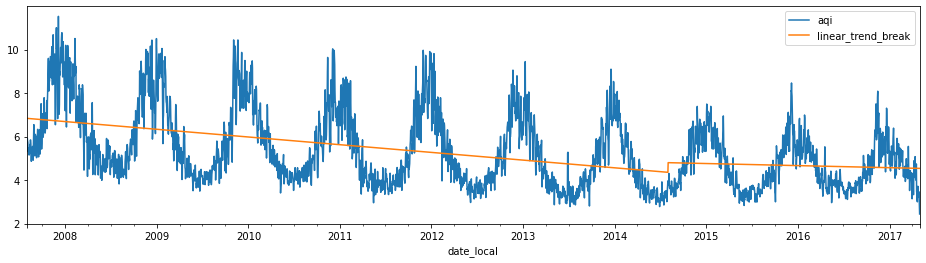

In [24]:
lm_break = LinearRegression().fit(X_break, y)

air_df['linear_trend_break'] = lm_break.predict(X_break)

air_df[['aqi','linear_trend_break']].plot();

# shift and also change in gradient

<a id='dws'></a>
## 3. Dealing with Seasonality

We may want to do more than just identifying the trend though. Modeling the seasonality would allow us to model not just the average behavior, but exact values during each season. It would also allow us to quantify the seasonal effects too.

A simple way to achieve this would be to add seasonal <font color='red'>dummy terms</font> to the baseline linear regression. This is known as <font color='red'>feature engineering</font> and can be a very powerful tool in Time Series analysis, allowing us to capture rather complex patterns with a few simple engineered variables added.

We shall add a feature indicating what month the dates are in and use that to help with our predictions.

In [25]:
air_df['month'] = air_df.index.month
X_monthly = air_df[['time_point','month']]
X_monthly.head()

,time_point,month
date_local,,
2007-08-01,0,8
2007-08-02,1,8
2007-08-03,2,8
2007-08-04,3,8
2007-08-05,4,8


We shall also perform a train-test split so that we can evaluate our forecasting predictions later on. 

The train-test split is unsuffled to ensure that the test set data comes after the train set. 

In [26]:
from sklearn.model_selection import train_test_split

X_monthly_train, X_monthly_test, y_train, y_test = train_test_split(X_monthly, y, shuffle=False, train_size=len(X[:'2014']))

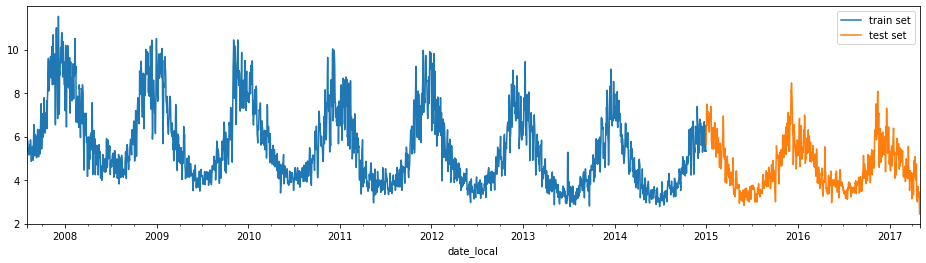

In [27]:
fig, ax = plt.subplots()
y_train.plot(ax=ax)
y_test.plot(ax=ax)
plt.legend(["train set","test set"]);

We one-hot encode the month information as it is a categorical value and then perform linear regression.

<!-- We do drop first because otherwise we will have co-linearites: high-correlation between the predictor variables, which can lead to problems.
- 1. Redundancy: two predictors might be providing the same information about the response variable.
- 2. The estimate of the effect a predictor on the response variable will tend to be less precise and less reliable.
- 3. An important predictor can become unimportant as that feature has a collinear relationship with other predictor.
 -->

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = ColumnTransformer(
      [('categorical', OneHotEncoder(drop='first'), ['month'])], # not to say that Jan and Dec are far away, let the model learn it
    remainder='passthrough'
)

lm_monthly = Pipeline([
    ('preprocess', encoder),
    ('model', LinearRegression())
])

lm_monthly.fit(X_monthly_train, y_train)
air_df['linear_monthly'] = lm_monthly.predict(X_monthly)

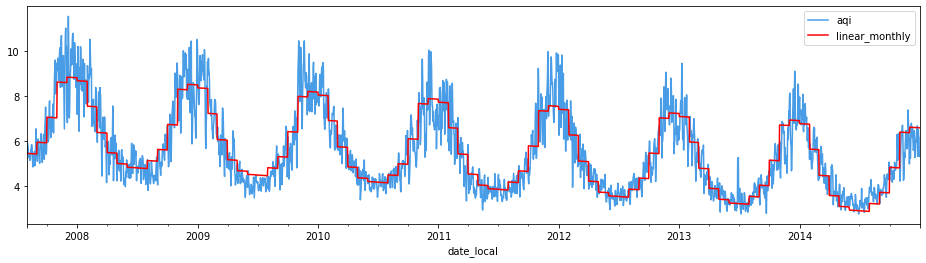

In [31]:
air_df[['aqi','linear_monthly']].loc[:'2014'].plot(color=['#499DE6','red']);

With this simple approach it is possible to separate the trend and seasonality components of the model.

<a id='t'></a>
### Trend

The coeffiecents for the monthly features indicate the seasonal effect they have.

In [32]:
pd.DataFrame(
    columns = calendar.month_name[2:],
    data = [lm_monthly['model'].coef_[:-1]]
)

,February,March,April,May,June,July,August,September,October,November,December
0,-1.100832,-2.236679,-3.099328,-3.556403,-3.695236,-3.700627,-3.3469,-2.827366,-1.696104,-0.111709,0.131198


To isolate the trend we can replace the seasonal coefficients with their average.

In [33]:
average_seasonal_effect = lm_monthly['model'].coef_[:-1].sum()/12
average_seasonal_effect

-2.1033322620880357

Using this average seasonal effect in the regression, inplace of the individual coefficients, allows us to get the trend line.

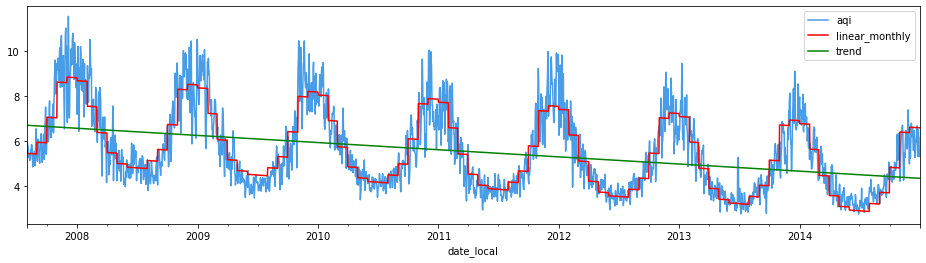

In [34]:
(
    air_df
    .assign(trend = lambda df: lm_monthly['model'].coef_[-1]*df['time_point'] 
                                + average_seasonal_effect 
                                + lm_monthly['model'].intercept_,
           )
    [['aqi','linear_monthly', 'trend']]
    .loc[:'2014']
    .plot(color=['#499DE6','red', 'green'])
);

<a id='s'></a>
### Seasonality

Subtracting the trend from the predictions allows us to separate the seasonality.

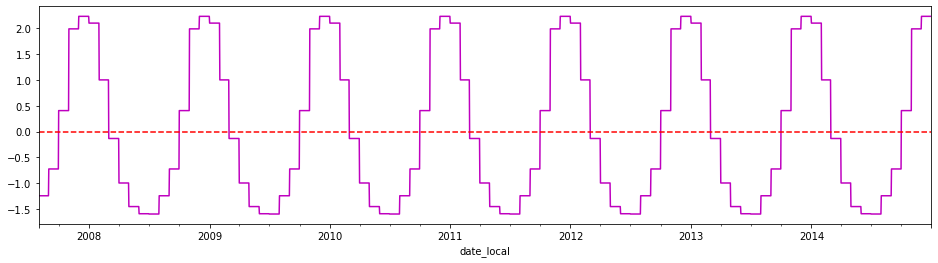

In [35]:
ax = (
    air_df
    .assign(residuals = lambda df: df['aqi'] - df['linear_monthly'],
            trend = lambda df: lm_monthly['model'].coef_[-1]*df['time_point'] 
                                + average_seasonal_effect 
                                + lm_monthly['model'].intercept_,
            seasonality = lambda df: df['linear_monthly']-df['trend']
           )
    ['seasonality']
    .loc[:'2014']
    .plot(c='m')
)
ax.axhline(0, color='r', linestyle='--');

Notice how we still have the seasonal waves but without the downwards trend.

This simple model with dummy features appears to reasonably capture the observed seasonality, even if has limitations. For one, the model assumes fixed monthly jumps, while the actual seasonality is likely to more complex.

<a id='gsf'></a>
## 4. Gradual Seasonal Filtering

Often seasonal effects do not come just as fixed spikes or drops. They may have gradually increasing and decreasing effects as their peak approaches and moves away in time. In such cases we may want to use a neater alternative to seasonal dummies: <font color='red'>gradual seasonal filters</font>.

There are a variety of such features that we could create. 

### Linear

A simple yet effective example are linear monthly spikes. They can be computed like so, 

$$ \phi(x_i) = \max( 1 - \frac{| x - x^*|}{n} , 0)$$

where $x$ is a given data point, $x^*$ is the peak of the current filter, and $n$ is the interval of growth/decline of the spike around the peak (e.g. 30 days). 

In [37]:
def gsf_feature_maker(center_day, days=np.arange(365), year_days=365, n=30):
    return np.maximum.reduce([
        np.fmax(-np.abs(days - center_day)/n + 1, 0),
        np.fmax(-np.abs(days + year_days - center_day)/n + 1, 0),  #ensures continuity across December-January
        np.fmax(-np.abs(days - year_days - center_day)/n + 1, 0) #ensures continuity across December-January
        ])

In practice, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak.

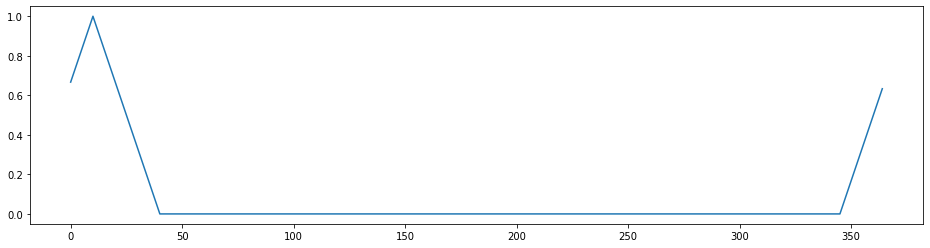

In [38]:
base = gsf_feature_maker(10)
plt.plot(base);

Such gradual filters could be especially handy when dealing with daily data that typically exhibits more gradual seasonal effects. 

A separate filter can be assigned to each potential seasonal peak — each month in the example below.

In [39]:
months_2008 = pd.date_range('2008-01-01', periods = 12, freq='MS')

month_peaks = pd.Series(
    index = months_2008.map(lambda data: data.month_name()),
    data = months_2008.map(lambda data: data.replace(day=15).dayofyear)
)

month_peaks.head()

January      15
February     46
March        75
April       106
May         136
dtype: int64

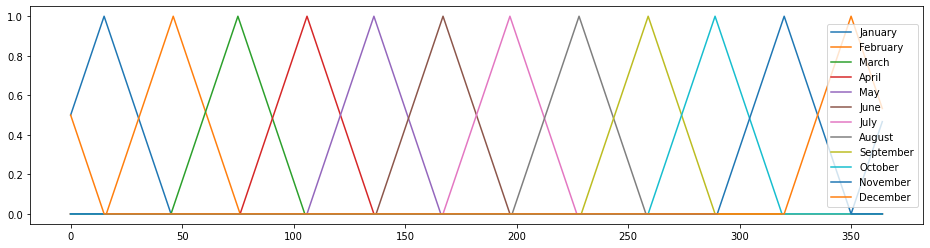

In [40]:
fig, ax = plt.subplots()
for month in month_peaks.index:
    peak = month_peaks.at[month]
    ax.plot(gsf_feature_maker(peak), label=month)
ax.legend(loc='right')

We can add this information as features and use it to model the Time Series data. 

It means that the effect is not felt uniformly across a month, but increases/decreases depending on the distance from the desginated centre.

In [41]:
X_gsf = air_df[['time_point']].copy()

days = X_gsf.index.dayofyear

for month in month_peaks.index:
    peak = month_peaks.at[month]
    X_gsf[month] = gsf_feature_maker(peak, days)
    
X_gsf.head()


,time_point,January,February,March,April,May,June,July,August,September,October,November,December
date_local,,,,,,,,,,,,,
2007-08-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.500000,0.0,0.0,0.0,0.0
2007-08-02,1,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,0.533333,0.0,0.0,0.0,0.0
2007-08-03,2,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.566667,0.0,0.0,0.0,0.0
2007-08-04,3,0.0,0.0,0.0,0.0,0.0,0.0,0.366667,0.600000,0.0,0.0,0.0,0.0
2007-08-05,4,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.633333,0.0,0.0,0.0,0.0


### Gaussian

Another commonly used option are filters based on a *Gaussian distribution*:

$$ \phi(x_i) = \exp [ - \frac{1}{2\alpha} (x-m_i)^2]$$

where $x$ is a given data point, $m_i$ is the peak of the current filter, and $\alpha$ is a parameter responsible for the spread of the distribution. 

In [42]:
def rbf_feature_maker(center_day, days=np.arange(365), year_days = 365, alpha = 0.005):
    return np.maximum.reduce([
        np.fmax(np.exp(-((days - center_day)**2) / 2*alpha), 0),
        np.fmax(np.exp(-((days + year_days - center_day)**2) / 2*alpha), 0), #ensures continuity for December-January
        np.fmax(np.exp(-((days - year_days - center_day)**2) / 2*alpha), 0)  #ensures continuity for December-January
        ]) 

Again, a filter like this translates into a variable with values the closer to 1 (or to 0), the closer (or the further) a particular date is from the given peak. However, the effect is much smoother.

Depending on $\alpha$, very steep or very gradual filters can be created.  Such gradual filters could be especially handy when dealing with daily (or even hourly) data that typically exhibits more gradual seasonal effects. 

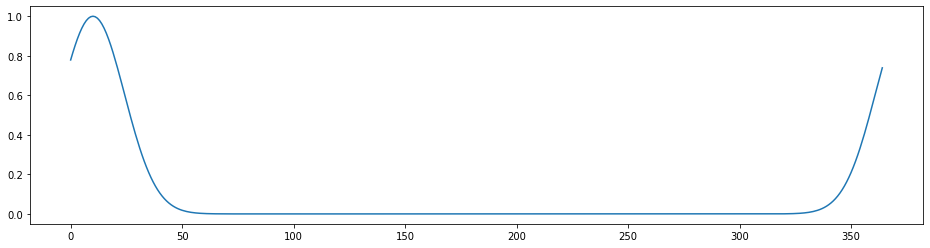

In [43]:
base = rbf_feature_maker(10, alpha = 0.005)
plt.plot(base);

### <mark>Exercise: Modelling with Gradual Seasonal Filters</mark>

Add Gaussian features that correspond to the different months and use them to help model the data. 
- How do the preditions compare visually to the model with seasonal dummy features?
- How is the performance affected by the $\alpha$ value?

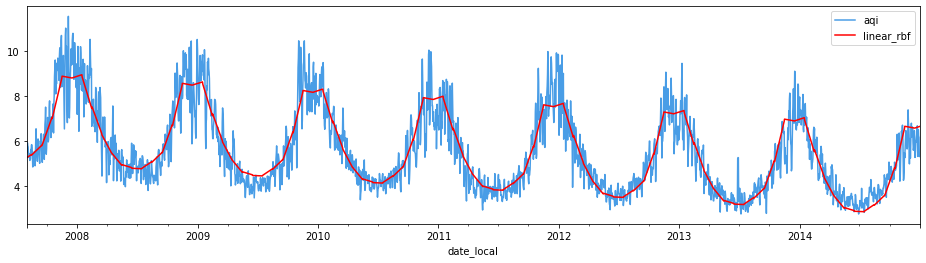

In [45]:
# %load answers/rbf.py
X_gsf = air_df[['time_point']].copy()

days = X_gsf.index.dayofyear

for month in month_peaks.index:
    peak = month_peaks.at[month]
    X_gsf[month] = gsf_feature_maker(peak, days)

X_gsf_train = X_gsf.loc[:'2014']
X_gsf_test = X_gsf.loc['2015':]

lm_rbf = LinearRegression()

lm_rbf.fit(X_gsf_train, y_train)

air_df['linear_rbf'] = lm_rbf.predict(X_gsf)

air_df[['aqi','linear_rbf']].loc[:'2014'].plot(color=['#499DE6','red']);


### Gradual Seasonal Filtering summary

**Pros** 

- simple feature engineering trick
- all variables are interpretable
- seasonal effects can be quantified
- focus on filtering out the long term season, other fluctuations can be modeled separately

**Cons** 

- the model can get a bit biased 
- the model may have issues if the seasonality changes over time (fixable)

<a id='sine'></a>
### BONUS: Fitting a Sinusoid Curve?

An alternative approach to using seasonal dummies or other similar features could be fitting a predetermined function that naturally mimics the behavior of our Time Series. In fact our data kind of looks like sine fluctuations, doesn't it?

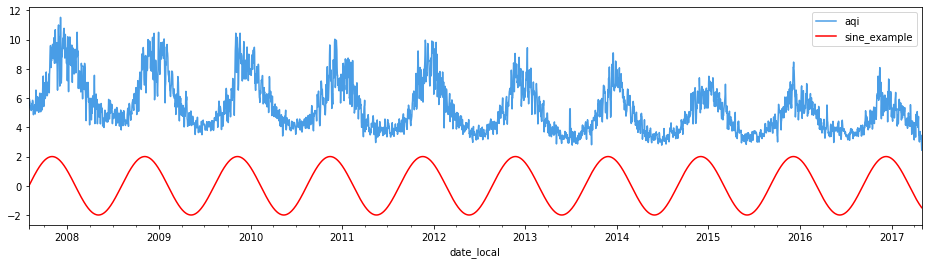

In [46]:
air_df['sine_example']=2*np.sin(0.017*air_df['time_point'])

air_df[['aqi', 'sine_example']].plot(color=['#499DE6','red']);

But how can we fit a sine curve? Is it still possible to use linear regression?

A standard linear model fitting a sine curve over a year would have the following form:

$$ y_i = w_0 + w_1 t_i + w_2 \sin{(\frac{2 \pi t_i}{365} + \Phi)} + \varepsilon_i$$

where $w_2$ determines the amplitude (gap between top and bottom parts) and $\Phi$ shifts the sine curve left/right along the x-axis. 

The problem with this though is that there are two parameters to learn ($w_2$ & $\Phi$) for a single linear component.

Fortunately we can use a very neat trick from Trigonometry that will allow us to separate the two:

$$ \sin{(a - b)} = \sin{(a)}\cos{(b)} - \cos{(a)}\sin{(b)}$$

Therefore:

$$ \sin{(2 \pi t_i + \Phi)} = \sin{(\frac{2 \pi t_i}{365})}\cos{(\Phi)} - \cos{(\frac{2 \pi t_i}{365})}\sin{(\Phi)}$$

Since $\sin{(\Phi)}$ and $\cos{(\Phi)}$ are just constants, we can incorporate them into the coefficients and simply fit the following linear model:

$$ y_i = w_0 + w_1 t_i + w_2 \sin{(\frac{2 \pi t_i}{365})} + w_3 \cos{(\frac{2 \pi t_i}{365})} + \varepsilon_i$$

We simply need to calculate the $\sin$ and $\cos$ components as new variables:

In [47]:
X_trig = (
    air_df[['time_point']]
    .assign(sin = lambda df: np.sin(2*np.pi*df['time_point']/365),
            cos = lambda df: np.cos(2*np.pi*df['time_point']/365),
#             sin_time = lambda df: df['sin']*df['time_point'],
#             cos_time = lambda df: df['cos']*df['time_point']        
    )

)
X_trig.head()

,time_point,sin,cos
date_local,,,
2007-08-01,0,0.000000,1.000000
2007-08-02,1,0.017213,0.999852
2007-08-03,2,0.034422,0.999407
2007-08-04,3,0.051620,0.998667
2007-08-05,4,0.068802,0.997630


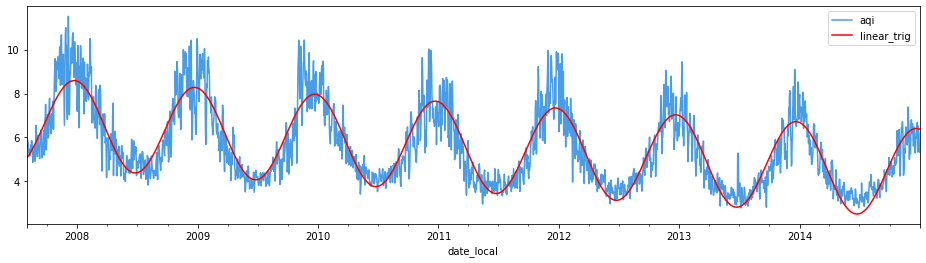

In [48]:
lm_trig = LinearRegression()

X_trig_train = X_trig.loc[:'2014']
X_trig_test = X_trig.loc['2015':]

lm_trig.fit(X_trig_train, y_train)

air_df['linear_trig'] = lm_trig.predict(X_trig)

air_df[['aqi','linear_trig']].loc[:'2014'].plot(color=['#499DE6','red']);

It looks quite naural, however, one remaining problem is that the fluctuations appear to shrink over time. 

*How could we fix this?*

### Sinusoidal fitting summary

Fitting a sine curve can be an example of a high bias & low variance seasonality model. We have less risk of overfitting, but perhaps we oversimplify the dynamics too much. Still, it may be a good choice for models with very regular seasonal cycles or simply when we require quick deseasonalization.

This example also serves as an introduction to a more advanced technique - [Fast Fourier Transform algorithm](https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/), that relies on combining multiple sine terms for seasonality modeling. It uses the famous result by French mathematician Joseph Fourier: 

> "a reasonably continuous and periodic function can be expressed as the sum of series of sine terms." 


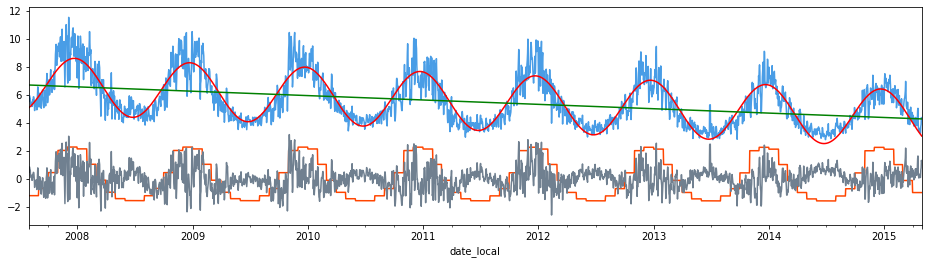

In [49]:
(
    air_df
    .assign(residuals = lambda df: df['aqi'] - df['linear_trig'],
            trend = lambda df: lm_trig.coef_[0]*air_df['time_point'] + lm_trig.intercept_,
            seasonality = lambda df: df['linear_monthly']-df['trend']
           )
    [['aqi','linear_trig','trend', 'seasonality', 'residuals']]
    .loc[:'2015-4']
    .plot(legend=False, color=['#499DE6','red', 'green', 'orangered', 'slategrey'])
);

<a id='od'></a>
## 5. Outlier detection

Having a reasonable model for seasonality, we can now also use it to better understand what was happening in the past. Most notably, we can identify periods that stand out from regular seasonal patterns. This brings us to outlier detection. While there are many techniques for that, a simple natural way would be to look for data points deviating from the model more than a certain threshold percentage:

In [50]:
air_df['outliers'] = np.where(((air_df['aqi'] - air_df['linear_rbf'])/air_df['linear_rbf']).abs() > 0.15,
                               air_df['aqi'],
                               np.nan)
air_df.loc[air_df['outliers'].notna()]

,aqi,time_point,linear_trend,linear_trend_break,month,linear_monthly,linear_rbf,sine_example,linear_trig,outliers
date_local,,,,,,,,,,
2007-08-29,6.548105,28,6.529551,6.809477,8,5.437629,5.576548,0.916455,5.787358,6.548105
2007-09-27,7.508475,57,6.509786,6.781355,9,5.932052,6.260461,1.648640,6.745985,7.508475
2007-10-09,7.784153,69,6.501608,6.769718,10,7.052924,6.753635,1.843834,7.149095,7.784153
2007-10-24,8.879781,84,6.491385,6.755172,10,7.039936,7.432137,1.979644,7.619814,8.879781
2007-10-25,9.189560,85,6.490703,6.754202,10,7.039070,7.493380,1.984196,7.649159,9.189560
...,...,...,...,...,...,...,...,...,...,...
2017-04-26,3.357143,3556,4.125082,4.538604,4,2.630326,2.440759,-1.380363,2.501673,3.357143
2017-04-27,3.214286,3557,4.124400,4.538342,4,2.629460,2.422966,-1.404766,2.472064,3.214286
2017-04-28,3.464286,3558,4.123718,4.538081,4,2.628594,2.405173,-1.428763,2.442801,3.464286


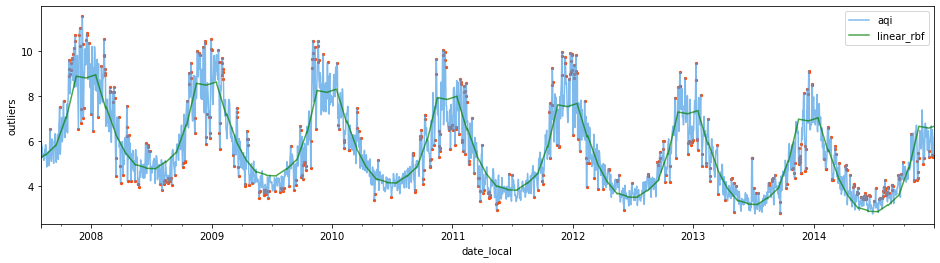

In [51]:
fig, ax = plt.subplots()
air_df[['aqi','linear_rbf']].loc[:'2014'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
air_df.loc[:'2014'].reset_index().plot(color='orangered', marker='.', ax=ax, 
                                       kind='scatter', x='date_local', y='outliers');

Let's examine the outliers year by year:

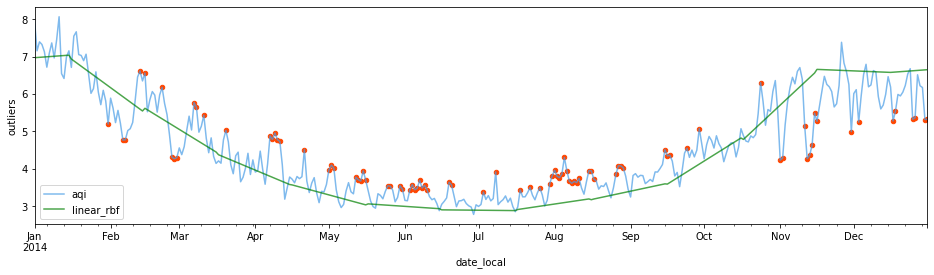

In [52]:
year_to_examine= '2014'

fig, ax = plt.subplots()
air_df[['aqi','linear_rbf']].loc[year_to_examine].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
air_df.loc[year_to_examine].reset_index().plot(color='orangered', ax=ax, kind='scatter', x='date_local', y='outliers');

Checking against a certain percentage threshold may be a bit arbitrary. That's why more advanced approaches to outlier detection use confidence bounds around the model instead. The example above should nonetheless illustrate the idea of how such techniques work.

<a id='eval'></a>
## 6. Forecast Evaluation for Seasonality Models

So far we have only assessed the performance of our models visually on past data (the data they were trained on). 

In practice, we want to use these models for forecasting. It would therefore be useful to compare the performance of the models on unseen data from the future.

In [ ]:
(
    air_df
    .loc['2015':]
    [['aqi', 'linear_monthly', 'linear_rbf', 'linear_trig']]
    .plot(color=['#499DE6','orangered', 'red', 'green'])
)

It looks like our models are better at predicting winter values rather than summer values.

The predictions are off for Summer 2016 in particular. Why might this be case?

Let's evaluate the Mean Absolute Percentage Error (MAPE) of each model and see which one actually did the best.

MAPE is a commonly used metric for evaluting time series data as it is scale independent, so it can be used to compare forecast performance between different Time Series (and different sections of Time Series).

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

print(f"MAPE for the model with dummy feaures is \
{round(mean_absolute_percentage_error(y_test, air_df['linear_monthly'].loc['2015':])*100,2)}")

print(f"MAPE for the (Gaussian) gsf model is \
{round(mean_absolute_percentage_error(y_test, air_df['linear_rbf'].loc['2015':])*100,2)}")

# print(f"MAPE for the sinusoid model is \
# {round(mean_absolute_percentage_error(y_test, air_df['linear_trig'].loc['2015':])*100,2)}")

Surprisingly, the model with seasonal dummies appears to perform (slightly) better than the GSF model. 

This should make us thinking and raise a few questions for the future:

- Are we using an adequate metric?
- Do we want to compare forecasts the the real noisy data or to smoothed series?
- How far in the future we want to forecast?


<a id='sum'></a>
## 7. Summary

Whilst modelling and forecasting time series data we have come across a few key points:
- Seasonality matters!
- Feature engineering is a way to turn your creativity into better models
- There are many ways to identify it
- Linear models are more powerful than people think
